In [1]:
%load_ext autoreload
%autoreload 2

In [70]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from matplotlib.ticker import MaxNLocator
import json
import ptitprince as pt
import pickle as pkl
# import contextily as ctx
from analysis import *
from ema_workbench import load_results
sns.set_theme(style="ticks")

In [54]:
# Load results
results = load_results('../results/scenarios=16, policies=16.tar.gz')
experiments, _ = results
experiments['scenario'] = experiments['scenario'].astype(int)

In [55]:
# Check whether all random seeds are unique
len(experiments['random_seed'].unique()), experiments['scenario'].max() - experiments['scenario'].min() + 1

(16, 16)

In [56]:
outcomes = prepare_outcomes_dataframe(results, add_policies=True)
outcomes.drop('years_in_poverty', axis=1, inplace=True)

In [57]:
# Convert columns to float
for col in outcomes.columns:
    if col not in ['scenario', 'policy', 'district', 'my_policy']:
        outcomes[col] = outcomes[col].astype(float)

## Graphs

In [79]:
# 'all', 'poor', 'poor_near_poor1.25', 'poor_near_poor2.0'
target_group_names = {'all+' : 'All', 'poor+' : 'Poor', 'poor_near_poor1.25+' : 'Poor and near-poor (1.25)', 'poor_near_poor2.0+' : 'Poor and near-poor (2.0)'}

In [74]:
target_group = 'poor_near_poor2.0+'
df = outcomes[outcomes['my_policy'].str.startswith(target_group)].copy()
df.rename({'district' : 'District'}, axis=1, inplace=True)
df['my_policy'] = df['my_policy'].astype('str')
df['my_policy'] = df['my_policy'].str.replace(f'{target_group}', '', regex=False)
df['my_policy'] = df['my_policy'].apply(lambda x: f'{x}%')
df.rename({'my_policy' : 'Top up'}, axis=1, inplace=True)
df['Top up'] = df['Top up'].sort_values()

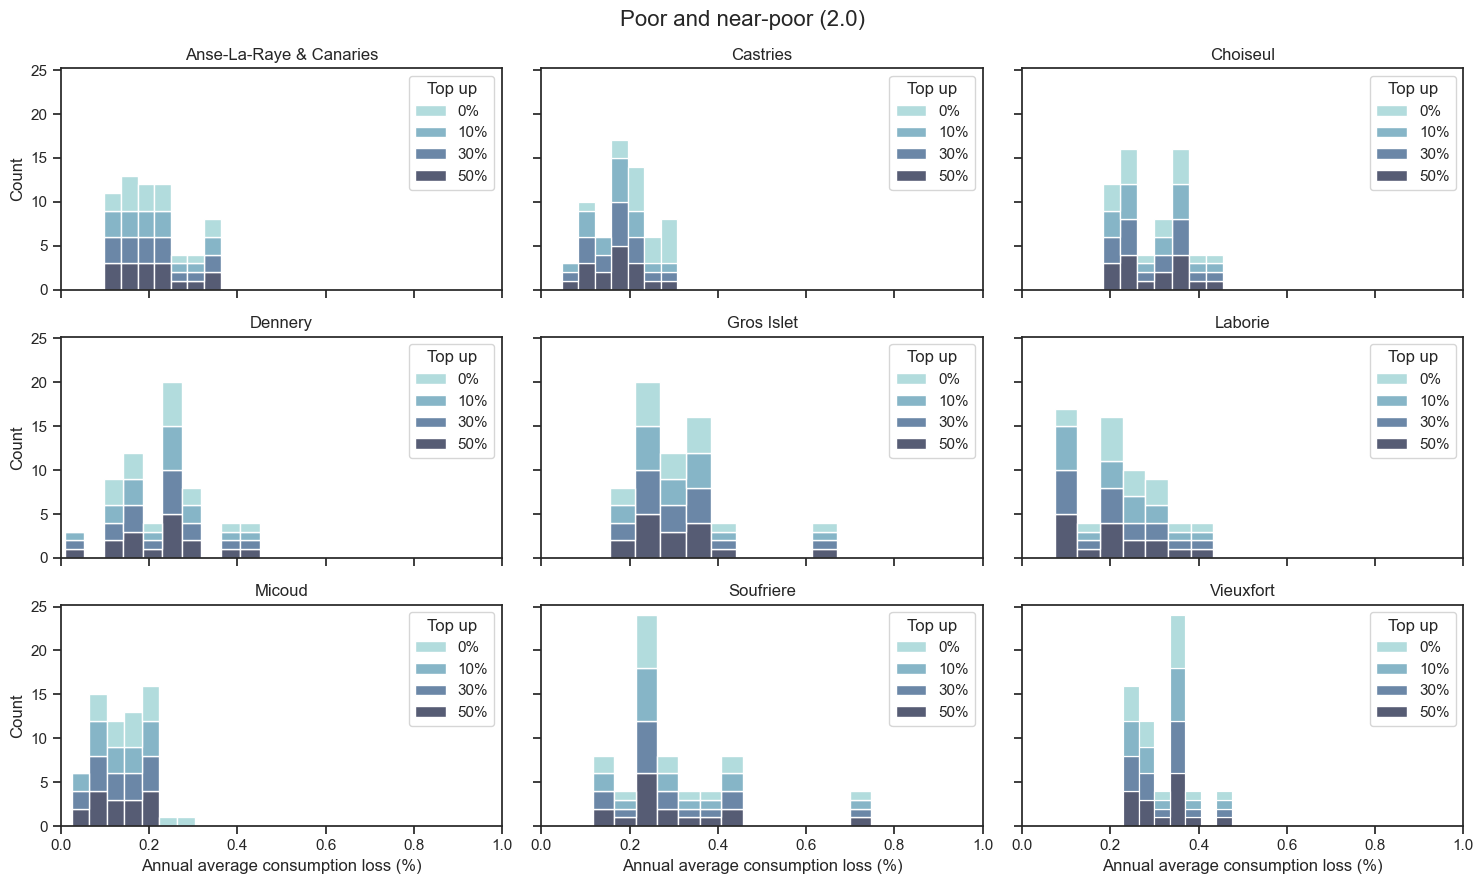

In [83]:
districts = df['District'].unique().tolist()
n_districts = len(districts)
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(5 * n_districts / 3, 3 * n_districts / 3), sharex=True, sharey=True)
colors = sns.color_palette('Set2', n_colors=len(districts))

for district in districts:
    data = df[df['District'] == district][['Top up', 'annual_average_consumption_loss_pct']]
    data.sort_values('Top up', inplace=True)
    if district == 'AnseLaRayeCanaries':
        district_name = 'Anse-La-Raye & Canaries'
    else:
        district_name = district
    i = districts.index(district) // 3
    j = districts.index(district) % 3
    color = colors[districts.index(district)]
    sns.histplot(data=data, 
                 x='annual_average_consumption_loss_pct', 
                 hue='Top up', 
                 ax=ax[i, j], 
                 multiple='stack', 
                 # shrink=.8,
                 palette="ch:rot=-.25,hue=1,light=.75"
                 )
    ax[i, j].set_title(district_name)
    ax[i, j].set_xlabel('Annual average consumption loss (%)')
    ax[i, j].set_ylabel('Count')
    ax[i, j].set_xlim(0, 1)
fig.suptitle(target_group_names[target_group], fontsize=16)
fig.tight_layout()

## Table

In [ ]:
outcomes = outcomes.drop(columns=['policy', 'scenario'])

In [ ]:
target_groups = outcomes['target_group'].unique().tolist()
top_ups = outcomes['top_up'].unique().tolist()
target_groups, top_ups

In [ ]:
outcomes_of_interest = ['annual_average_consumption_loss_pct', 'n_new_poor']
outcomes.groupby(['district', 'target_group', 'top_up']).mean()[outcomes_of_interest][:25]

In [ ]:
outcomes_of_interest = ['annual_average_consumption_loss_pct', 'n_new_poor']
outcomes.drop('district', axis=1).groupby(['target_group', 'top_up']).mean()[outcomes_of_interest]

In [ ]:
vertical = ['None', '10%', '30%', '50%']
horizontal = ['All', 'Poor', 'Poor & Near Poor (1.25)', 'Poor & Near Poor (2.0)']
columns = ['Vertical expansion', 'Horizontal expansion', 
           'Average reduction in consumption loss (%)', 
           'Average number of people prevented from falling into poverty']